# **COMP 2211 Exploring Artificial Intelligence** #
## Lab 6 Multilayer Perceptron ##

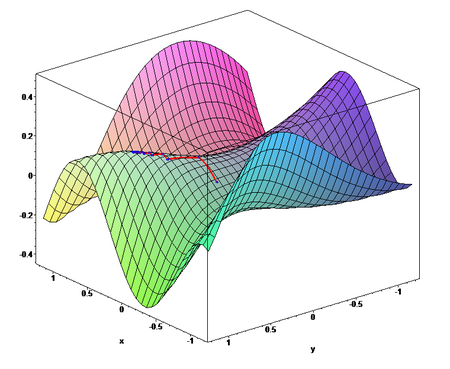

# **Review** ##
Before we start, let's have a quick recap of the lecture.

## Multilayer Perceptron

Unlike single-layer perceptron, increasing the number of layers enhances the model representation power to handle a broader range of problems.

Multilayer perceptron generally consists of 3 types of layers:
*   Input layer
*   Hidden layer
*   Output layer



Example playground:
> __https://playground.tensorflow.org/__

## Loss function

As the parameters (weights and biases) are updated by backpropagation, it is important to define the loss function so that the derivative can be computed step by step from the loss function.
> Basically, the loss function is the difference between the ground truth and your prediction result; we aim to minimize the loss to make the prediction closer to the ground truth.

> In Keras, you can find the available loss functions at https://keras.io/api/losses/.

Following is a visulization for common loss used for classfication and regression on 1-dimension data. The x axis is `y_pred-y_label`. You can see how these loss function penalize the incorrect prediction

/tmp/ipykernel_3843373/544768023.py:21: RuntimeWarning: invalid value encountered in log
  cross_entropy_loss = -np.log(x)


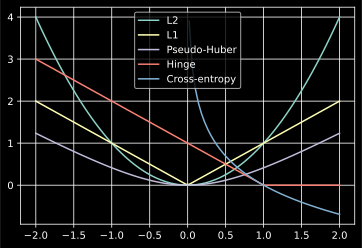

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Define the x values for the plot
x = np.linspace(-2, 2, 100)

# Define the L2 loss function
l2_loss = x**2

# Define the L1 loss function
l1_loss = np.abs(x)

# Define the Pseudo-Huber loss function
delta = 1
pseudo_huber_loss = delta**2 * (np.sqrt(1 + (x/delta)**2) - 1)

# Define the Hinge loss function
hinge_loss = np.maximum(0, 1 - x)

# Define the Cross-entropy loss function
cross_entropy_loss = -np.log(x)

# Plot the loss functions
plt.plot(x, l2_loss, label='L2')
plt.plot(x, l1_loss, label='L1')
plt.plot(x, pseudo_huber_loss, label='Pseudo-Huber')
plt.plot(x, hinge_loss, label='Hinge')
plt.plot(x, cross_entropy_loss, label='Cross-entropy')
plt.grid()
plt.legend()
plt.show()

Here is a table summarizing the properties and benefits of the different loss functions that we have just explored:

| Loss function | Use | Benefits | Disadvantages | 
| --- | --- | --- | --- | 
| L2 | Regression | More stable | Less robust | 
| L1 | Regression | More robust | Less stable | 
| Pseudo-Huber | Regression | More robust and stable | One more parameter |
| Hinge | Classification | Creates a max margin for use in SVM | Unbounded loss affected by outliers | 
| Cross-entropy | Classification | More stable | Unbounded loss, less robust |

## Gradient Descent
We update the parameter $\rho$ by calculating its gradient $\nabla \rho$ for a learning rate of $\eta$,
> $\rho = \rho - \eta \nabla \rho$

If you are interested in more details of backpropagation and how to compute the gradient for nodes in different layers, you may check out the example and illustration in the youtube video by 3blue1brown at https://www.youtube.com/watch?v=Ilg3gGewQ5U.

To give a basic concept here, for example, we have the below network structure.

Given that $a_i = f_i(w_{i-1} a_{i-1})$ where $a_0 = x$, $w_i$ is the weight parameter and $f_i$ is the activation function of layer i in the network.

Network: <br>
input $x$  -($w_1$)-> $a_1,f_1$ -($w_2$)-> $a_2, f_2$ -($w_3$)-> $a_3, f_3$ --> $y$ --> Loss function $L$

Let's say we now want to update $w_2$ by backpropagation. Then we will need to compute $w_2 = w_2 - \eta \nabla w_2$

$\nabla w_2 = \frac{\partial L}{\partial w_2} = \frac{\partial L}{\partial f_3}\frac{\partial f_3}{\partial a_3}\frac{\partial a_3}{\partial f_2}\frac{\partial f_2}{\partial a_2}\frac{\partial a_2}{\partial w_2}$

while $\nabla w_3 = \frac{\partial L}{\partial w_3} = \frac{\partial L}{\partial f_3}\frac{\partial f_3}{\partial a_3}\frac{\partial a_3}{\partial w_3}$, and you will find that some computation results can be reused.

Following provides a simple animation for how gradient descent works on regressing a basic function $3x^2$

In [20]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
plt.style.use("dark_background")

from matplotlib import animation

def grad_1D(expr, x_values, learning_rate, training_epochs, display_animation=False):
    """
    expr : Sympy expression like 3*x**2 (x symbol)
    x_values : np.linspace(a,b, n)
    learning_rate, training_epochs = z, r
    display_animation : if True, will return two objects to visualizing it (example below)
    """

    x = sp.symbols("x")
    func = sp.lambdify(x, expr, "numpy")
    deriv = sp.diff(expr)
    deriv_func = sp.lambdify(x, deriv, "numpy")
    
    #algorithm for Gradient Descent
    local_min = np.random.choice(x_values,1)
    initial_local_min = local_min
    print(f"Initial Random Local Min {initial_local_min}")
    model_params = np.zeros((training_epochs, 2)) #shape epochs x 2 cols
    for i in range(0, training_epochs):
        grad = deriv_func(local_min)
        local_min = local_min - (grad*learning_rate)
        model_params[i,0] = local_min[0]
        model_params[i,1] = grad[0]     
    print(f"Final Local Min after {training_epochs} epochs: {local_min}")
    
    
    if display_animation:
        #prepare animation
        grad_fig, ax = plt.subplots(figsize=(12,6), dpi=100)
        ax.plot(x_values, func(x_values), label=f"${sp.latex(expr)}$")
        ax.plot(x_values, deriv_func(x_values), label=f"dy/dx ${sp.latex(deriv)}$")

        plt.title(f"Empirical Local Minimum: {local_min[0]}")
        plt.axhline(0, color='white',linewidth=0.5)
        plt.axvline(0, color='white',linewidth=0.5)
        plt.grid(color="gray", linestyle="--", linewidth=0.5)
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.legend()
        plt.close()
        def tangent_line(x, x1, y1):
            # m*x+b
            return deriv_func(x1)*(x-x1) + y1
 
        title = ax.set_title('', fontweight="bold")
        local_min_scat = ax.scatter(initial_local_min, func(initial_local_min), color="orange")
        initial_tangent_range = np.linspace(initial_local_min-0.5, initial_local_min+0.5, 10)
        tangent_plot = ax.plot(initial_tangent_range, tangent_line(x=initial_tangent_range,
                                                                   x1=initial_local_min,
                                                                   y1=func(initial_local_min)), linestyle="--",  color="orange", linewidth=2)[0]
        grad_annotation = ax.annotate(
            'Gradient={0:2f}'.format(deriv_func(initial_local_min[0])),
            xy=(initial_local_min,func(initial_local_min)), xytext=(initial_local_min,func(initial_local_min)+1),
            arrowprops = {'arrowstyle': "-", 'facecolor' : 'orange'},
            textcoords='data', color='orange' , rotation=20, fontweight="bold"
        )
        def drawframe(epoch):
            title.set_text('Epoch={0:4d}'.format(epoch, model_params[epoch, 1]))
            x1 = model_params[epoch, 0]
            y1 = func(model_params[epoch, 0])
            local_min_scat.set_offsets((x1, y1))
            tangent_range = np.linspace(x1-0.5, x1+0.5, 10)
            tangent_values = tangent_line(x=tangent_range, x1=x1 ,y1=y1)
            tangent_plot.set_xdata(tangent_range)
            tangent_plot.set_ydata(tangent_values)
            grad_annotation.set_position((x1, y1+1))
            grad_annotation.xy = (x1, y1)
            grad_annotation.set_text('Gradient={0:2f}'.format(model_params[epoch, 1]))
            return local_min_scat,
 
        # blit=True re-draws only the parts that have changed.
        anim = animation.FuncAnimation(grad_fig, drawframe, frames=training_epochs, repeat=False, interval=500, blit=True) 
        writer = animation.PillowWriter(fps=30,
                                        metadata=dict(artist='Me'),
                                        bitrate=1800)
        return anim, writer

The following code generate the demo for gradient descent, you can change the learning rate and see how learning rate influence the convergence speed

In [21]:
x = sp.symbols("x")

x_values = np.linspace(-2,2,20)
anim, writer = grad_1D(expr=3*x**2, #it calculates the f'(x) automatically 
                       x_values=x_values, learning_rate=0.01, training_epochs=50, display_animation=True)
from IPython.display import HTML
HTML(anim.to_html5_video()) #render the video in jupyterlab

Initial Random Local Min [-0.52631579]
Final Local Min after 50 epochs: [-0.02385828]


## The procedure of applying MLP to a practical problem

1. Import the required libraries and define a global variable
2. Load the data
3. Explore the data and preprocess the data
4. Normalize the data
5. Build the model
6. Compile the model
7. Train the model
8. Evaluate the model accuracy
9. Save the model
10. Use the model

In the official documentation of Keras, there is a simple demo for the pipeline to apply MLP to solve a practical image classificantion problem. Please check https://keras.io/examples/vision/mlp_image_classification/ 

## Some remarks for MLP


-   You may want to keep the number of layers at a reasonable amount.
    - Normally a really deep neural network model composed solely of dense layers would not perform well because of the gradient exploring/vanishing problem.

-   Adding regularizations helps keep the weights small, so the model is less likely to have a large variance (i.e. be sensitive to noise and fluctuations in data).

-   To backpropagate, it is important to choose activation functions that are differentiable. <br> In addition, activation functions in the hidden layers are used to add non-linearity to the neural network, thus enabling a greater model representation power.
<br>
-   For the output layer, the activation function used depends on the classification type:
    - Binary classification: One node, sigmoid activation.
    - Multiclass classification: One node per class, softmax activation
    - Multilabel classification: One node per class, sigmoid activation
    - Regression: Onde node, linear activation
<br>
-   Setting batch size (minibatch gradient descent) but not training an iteration on a single batch with all samples (batch gradient descent) has the following benefits:
    - Less memory consumption.
    - Faster training time within an iteration.
    - Easier to get out of local minima.


## Layers

You will mainly work with these four types of layers.

You can find sample input and output of each layer in the documentation of Keras.  

- Flatten(): https://keras.io/api/layers/reshaping_layers/flatten/
    - Flattens the input. Does not affect the batch size. Note that if inputs are shaped `(batch,)` without a feature axis, then flattening adds an extra channel dimension and output shape is `(batch, 1)`.
- Dense(): https://keras.io/api/layers/core_layers/dense/
    - Regular densely-connected NN layer. Dense implements the operation: `output = activation(dot(input, kernel) + bias)` where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True). Note: If the input to the layer has a rank greater than 2, Dense computes the dot product between the inputs and the kernel along the last axis of the inputs and axis 0 of the kernel (using tf.tensordot). For example, if input has dimensions `(batch_size, d0, d1)`, then we create a kernel with shape `(d1, units)`, and the kernel operates along axis 2 of the input, on every sub-tensor of shape `(1, 1, d1)` (there are `batch_size * d0` such sub-tensors). The output in this case will have shape `(batch_size, d0, units)`.

- Dropout(): https://keras.io/api/layers/regularization_layers/dropout/
    - The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1 / (1 - rate) such that the sum over all inputs is unchanged. Note that the Dropout layer only applies when training is set to True in call(), such that no values are dropped during inference. When using model.fit, training will be appropriately set to True automatically. In other contexts, you can set the argument explicitly to True when calling the layer. (This is in contrast to setting trainable=False for a Dropout layer. trainable does not affect the layer's behavior, as Dropout does not have any variables/weights that can be frozen during training.)

- BatchNormalization(): https://keras.io/api/layers/normalization_layers/batch_normalization/
    - Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1. Importantly, batch normalization works differently during training and during inference. 
    - During training (i.e. when using `fit()` or when calling the layer/model with the argument training=True), the layer normalizes its output using the mean and standard deviation of the current batch of inputs. That is to say, for each channel being normalized, the layer returns `gamma * (batch - mean(batch)) / sqrt(var(batch) + epsilon) + beta`. During inference (i.e. when using `evaluate()` or `predict()` or when calling the layer/model with the argument `training=False` (which is the default)), the layer normalizes its output using a moving average of the mean and standard deviation of the batches it has seen during training. That is to say, it returns `gamma * (batch - self.moving_mean) / sqrt(self.moving_var+epsilon) + beta`.



## Self-learning materials

1. Multi-class vs Multi-label classification: \\
https://medium.com/mlearning-ai/multi-class-vs-multi-label-classification-whats-the-difference-2840a87c8dfe

2. Batch, Mini Batch and Stochastic (or single-instance) gradient descent: \\
https://sweta-nit.medium.com/batch-mini-batch-and-stochastic-gradient-descent-e9bc4cacd461

3. Regularization: \\
https://towardsdatascience.com/a-comprehensive-guide-of-regularization-techniques-in-deep-learning-c671bb1b2c67

4. Dropout: \\
https://towardsdatascience.com/dropout-in-neural-networks-47a162d621d9